# library import

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# import xgboost
import xgboost
from xgboost import XGBRegressor
# , plot_tree, plot_importance

In [2]:
data_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
sub_df   = pd.read_csv('sample_submission.csv')
data_df

date  precipitation  temp_mean  temp_highest  temp_lowest  PM10  \
0     2018-01-01            NaN       -1.3           3.8         -5.1  34.0   
1     2018-01-02            NaN       -1.8           1.8         -4.3  36.0   
2     2018-01-03            NaN       -4.7          -0.4         -7.1  31.0   
3     2018-01-04            NaN       -4.7          -0.7         -8.7  39.0   
4     2018-01-05            NaN       -3.0           1.6         -5.6  51.0   
...          ...            ...        ...           ...          ...   ...   
1090  2020-12-27            0.0        5.8          10.0          1.4  70.0   
1091  2020-12-28            1.3        6.7          11.4          4.2  66.0   
1092  2020-12-29            0.2        0.1           4.3         -6.2  69.0   
1093  2020-12-30            NaN      -10.9          -6.2        -12.9  39.0   
1094  2020-12-31            0.0       -8.9          -5.0        -12.9  28.0   

      PM2.5  humidity  sunshine_sum  sunshine_rate  wind_mean  wind_max  \
0      17.0      39.1           8.3           86.5        1.4       3.8   
1      22.0      42.0           7.9           82.3        1.8       4.9   
2      19.0      42.3           8.6           88.7        2.2       3.5   
3      24.0      43.0           6.2           63.9        1.4       3.5   
4      35.0      48.4           8.2           84.5        1.7       3.6   
...     ...       ...           ...            ...        ...       ...   
1090   42.0      62.9           5.9           61.5        1.8       2.8   
1091   44.0      72.1           8.0           83.3        1.4       3.1   
1092   46.0      70.8           0.0            0.0        2.9       6.1   
1093   15.0      55.5           8.3           86.5        4.1       6.2   
1094   12.0      53.9           6.0           62.5        2.4       4.2   

      rental  
0       4950  
1       7136  
2       7156  
3       7102  
4       7705  
...      ...  
1090   37103  
1091   46912  
1092   35747  
1093   22488  
1094   24535  

[1095 rows x 13 columns]

# 결측값 확인

## 데이터 칼럼/의미 확인

In [3]:
data_df.columns

Index(['date', 'precipitation', 'temp_mean', 'temp_highest', 'temp_lowest',
       'PM10', 'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate',
       'wind_mean', 'wind_max', 'rental'],
      dtype='object')

### 의미확인

>date: 날짜
precipitation: 강수량(mm)

> temp_mean: 평균 기온(℃)
temp_highest: 최고 기온(℃)
temp_lowest: 최저 기온(℃)

> PM10: 미세먼지(㎍/㎥)
PM2.5: 초미세먼지(㎍/㎥)

> humidity: 습도(%rh)

> sunshine_sum: 일조합
sunshine_rate: 일조율

> wind_mean: 평균 풍속(m/s)
wind_max: 최대 풍속(m/s)

> rentals : 따릉이 대여량

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1095 non-null   object 
 1   precipitation  417 non-null    float64
 2   temp_mean      1095 non-null   float64
 3   temp_highest   1095 non-null   float64
 4   temp_lowest    1095 non-null   float64
 5   PM10           1028 non-null   float64
 6   PM2.5          1027 non-null   float64
 7   humidity       1095 non-null   float64
 8   sunshine_sum   1090 non-null   float64
 9   sunshine_rate  1095 non-null   float64
 10  wind_mean      1095 non-null   float64
 11  wind_max       1095 non-null   float64
 12  rental         1095 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 111.3+ KB


#### data_df['date'] : object -> datetime 으로 변경

In [5]:
from datetime import datetime
import time
data_df['date'] = pd.to_datetime(data_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
data_df.head()

date  precipitation  temp_mean  temp_highest  temp_lowest  PM10  \
0 2018-01-01            NaN       -1.3           3.8         -5.1  34.0   
1 2018-01-02            NaN       -1.8           1.8         -4.3  36.0   
2 2018-01-03            NaN       -4.7          -0.4         -7.1  31.0   
3 2018-01-04            NaN       -4.7          -0.7         -8.7  39.0   
4 2018-01-05            NaN       -3.0           1.6         -5.6  51.0   

   PM2.5  humidity  sunshine_sum  sunshine_rate  wind_mean  wind_max  rental  
0   17.0      39.1           8.3           86.5        1.4       3.8    4950  
1   22.0      42.0           7.9           82.3        1.8       4.9    7136  
2   19.0      42.3           8.6           88.7        2.2       3.5    7156  
3   24.0      43.0           6.2           63.9        1.4       3.5    7102  
4   35.0      48.4           8.2           84.5        1.7       3.6    7705

### 결측치 처리는 어떻게 할 것인지에 대해서 생각

In [6]:
data_df.isnull().sum()

date               0
precipitation    678
temp_mean          0
temp_highest       0
temp_lowest        0
PM10              67
PM2.5             68
humidity           0
sunshine_sum       5
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
dtype: int64

In [7]:
test_df['date'][0].year

2021

In [8]:
# date 에서 year 만 따로 뽑았음
data_df['date_year'] = 0
for i in range(len(data_df['date'])):
    data_df['date_year'][i] = data_df['date'][i].year
# print(data_df['date_year'])

# date 에서 year 를 제외한 Month, Day 만 넣었음.
data_df['date_month_day'] = 0
for i in range(len(data_df['date'])):
    data_df['date_month_day'][i] = data_df['date'][i].strftime('%m-%d')
# data_df['date_month_day']

# date 에서 year 만 따로 뽑았음
test_df['date_year'] = 0
for i in range(len(test_df['date'])):
    test_df['date_year'][i] = test_df['date'][i].year
# print(data_df['date_year'])

# date 에서 year 를 제외한 Month, Day 만 넣었음.
test_df['date_month_day'] = 0
for i in range(len(test_df['date'])):
    test_df['date_month_day'][i] = test_df['date'][i].strftime('%m-%d')
# data_df['date_month_day']

/var/folders/wg/5chskr095sb443gt9wr8vplw0000gn/T/ipykernel_2657/965170762.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['date_year'][i] = data_df['date'][i].year
/var/folders/wg/5chskr095sb443gt9wr8vplw0000gn/T/ipykernel_2657/965170762.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['date_month_day'][i] = data_df['date'][i].strftime('%m-%d')
/var/folders/wg/5chskr095sb443gt9wr8vplw0000gn/T/ipykernel_2657/965170762.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [9]:
lst = list()
lst = [i*15 for i in range(8)]
print(lst)

[0, 15, 30, 45, 60, 75, 90, 105]


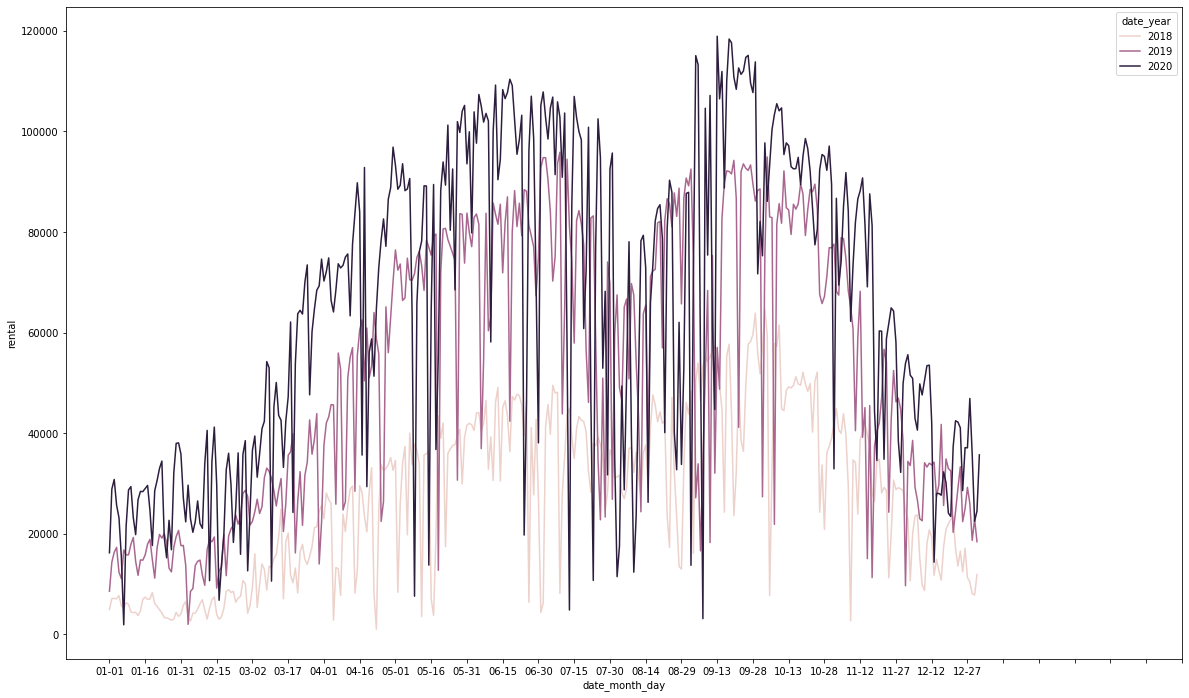

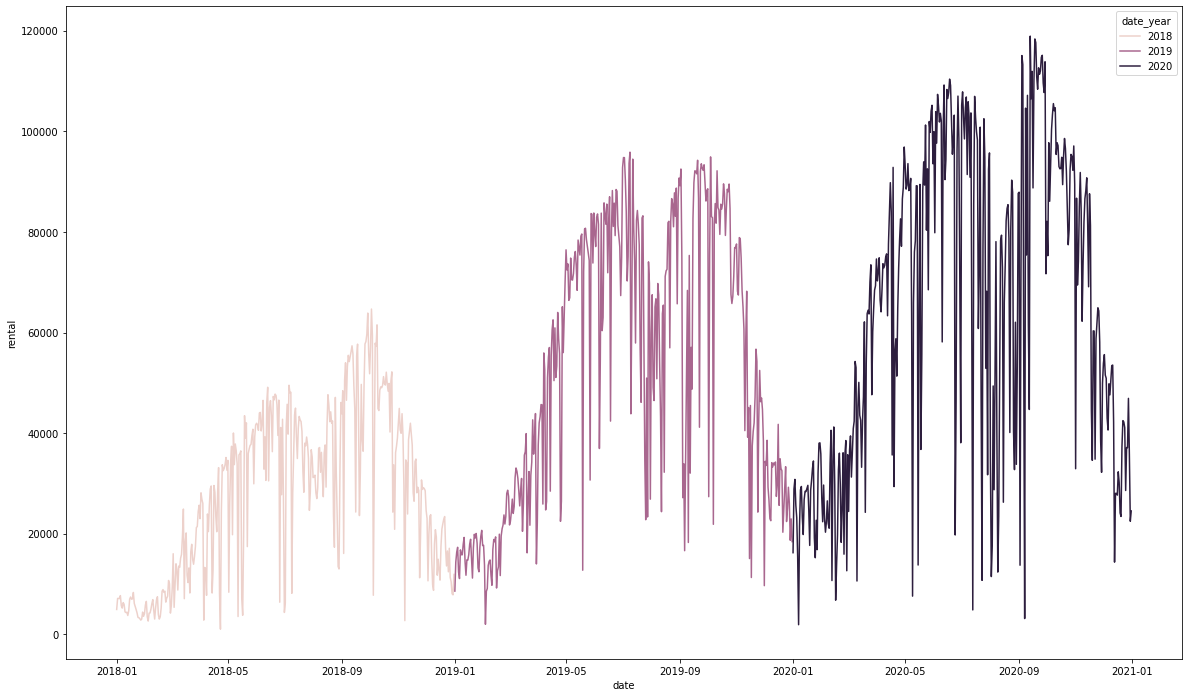

In [10]:
# plt.figure(figsize = (20,12))
# sns.lineplot(x = 'date_month_day', y = 'rental', data = data_df, hue = 'date_year')
# lst = list()
# lst = [i*15 for i in range(31)]
# plt.xticks(lst)
# plt.show()

# plt.figure(figsize = (20,12))
# sns.lineplot(x = 'date', y = 'rental', data = data_df, hue = 'date_year')
# plt.show()

In [11]:
data_df['rental'].groupby(data_df.date_year).agg('median')

date_year
2018    28806.0
2019    54222.5
2020    68314.0
Name: rental, dtype: float64

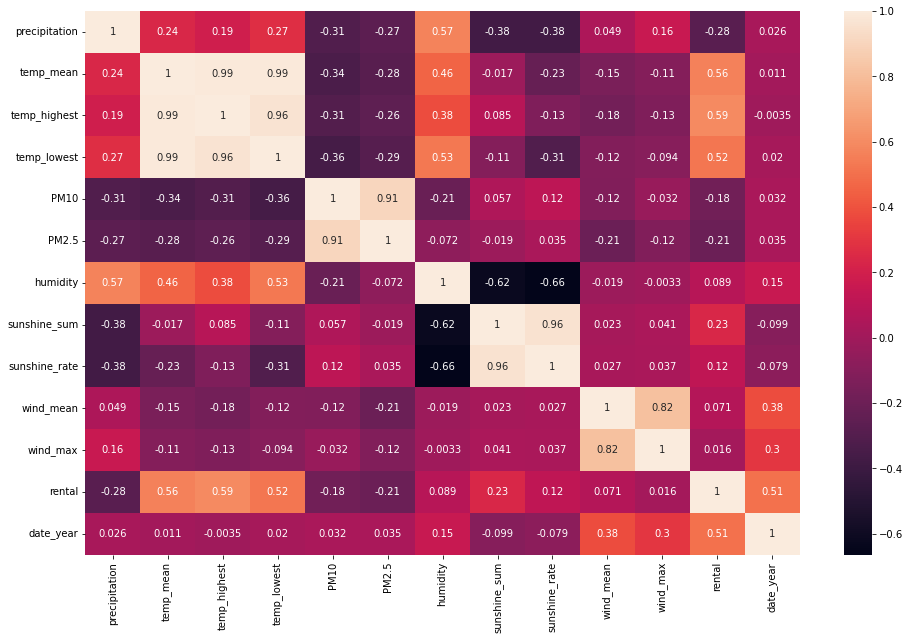

In [12]:
# plt.figure(figsize = (16,10))
# sns.heatmap(data_df.corr(),annot = True)
# plt.show()

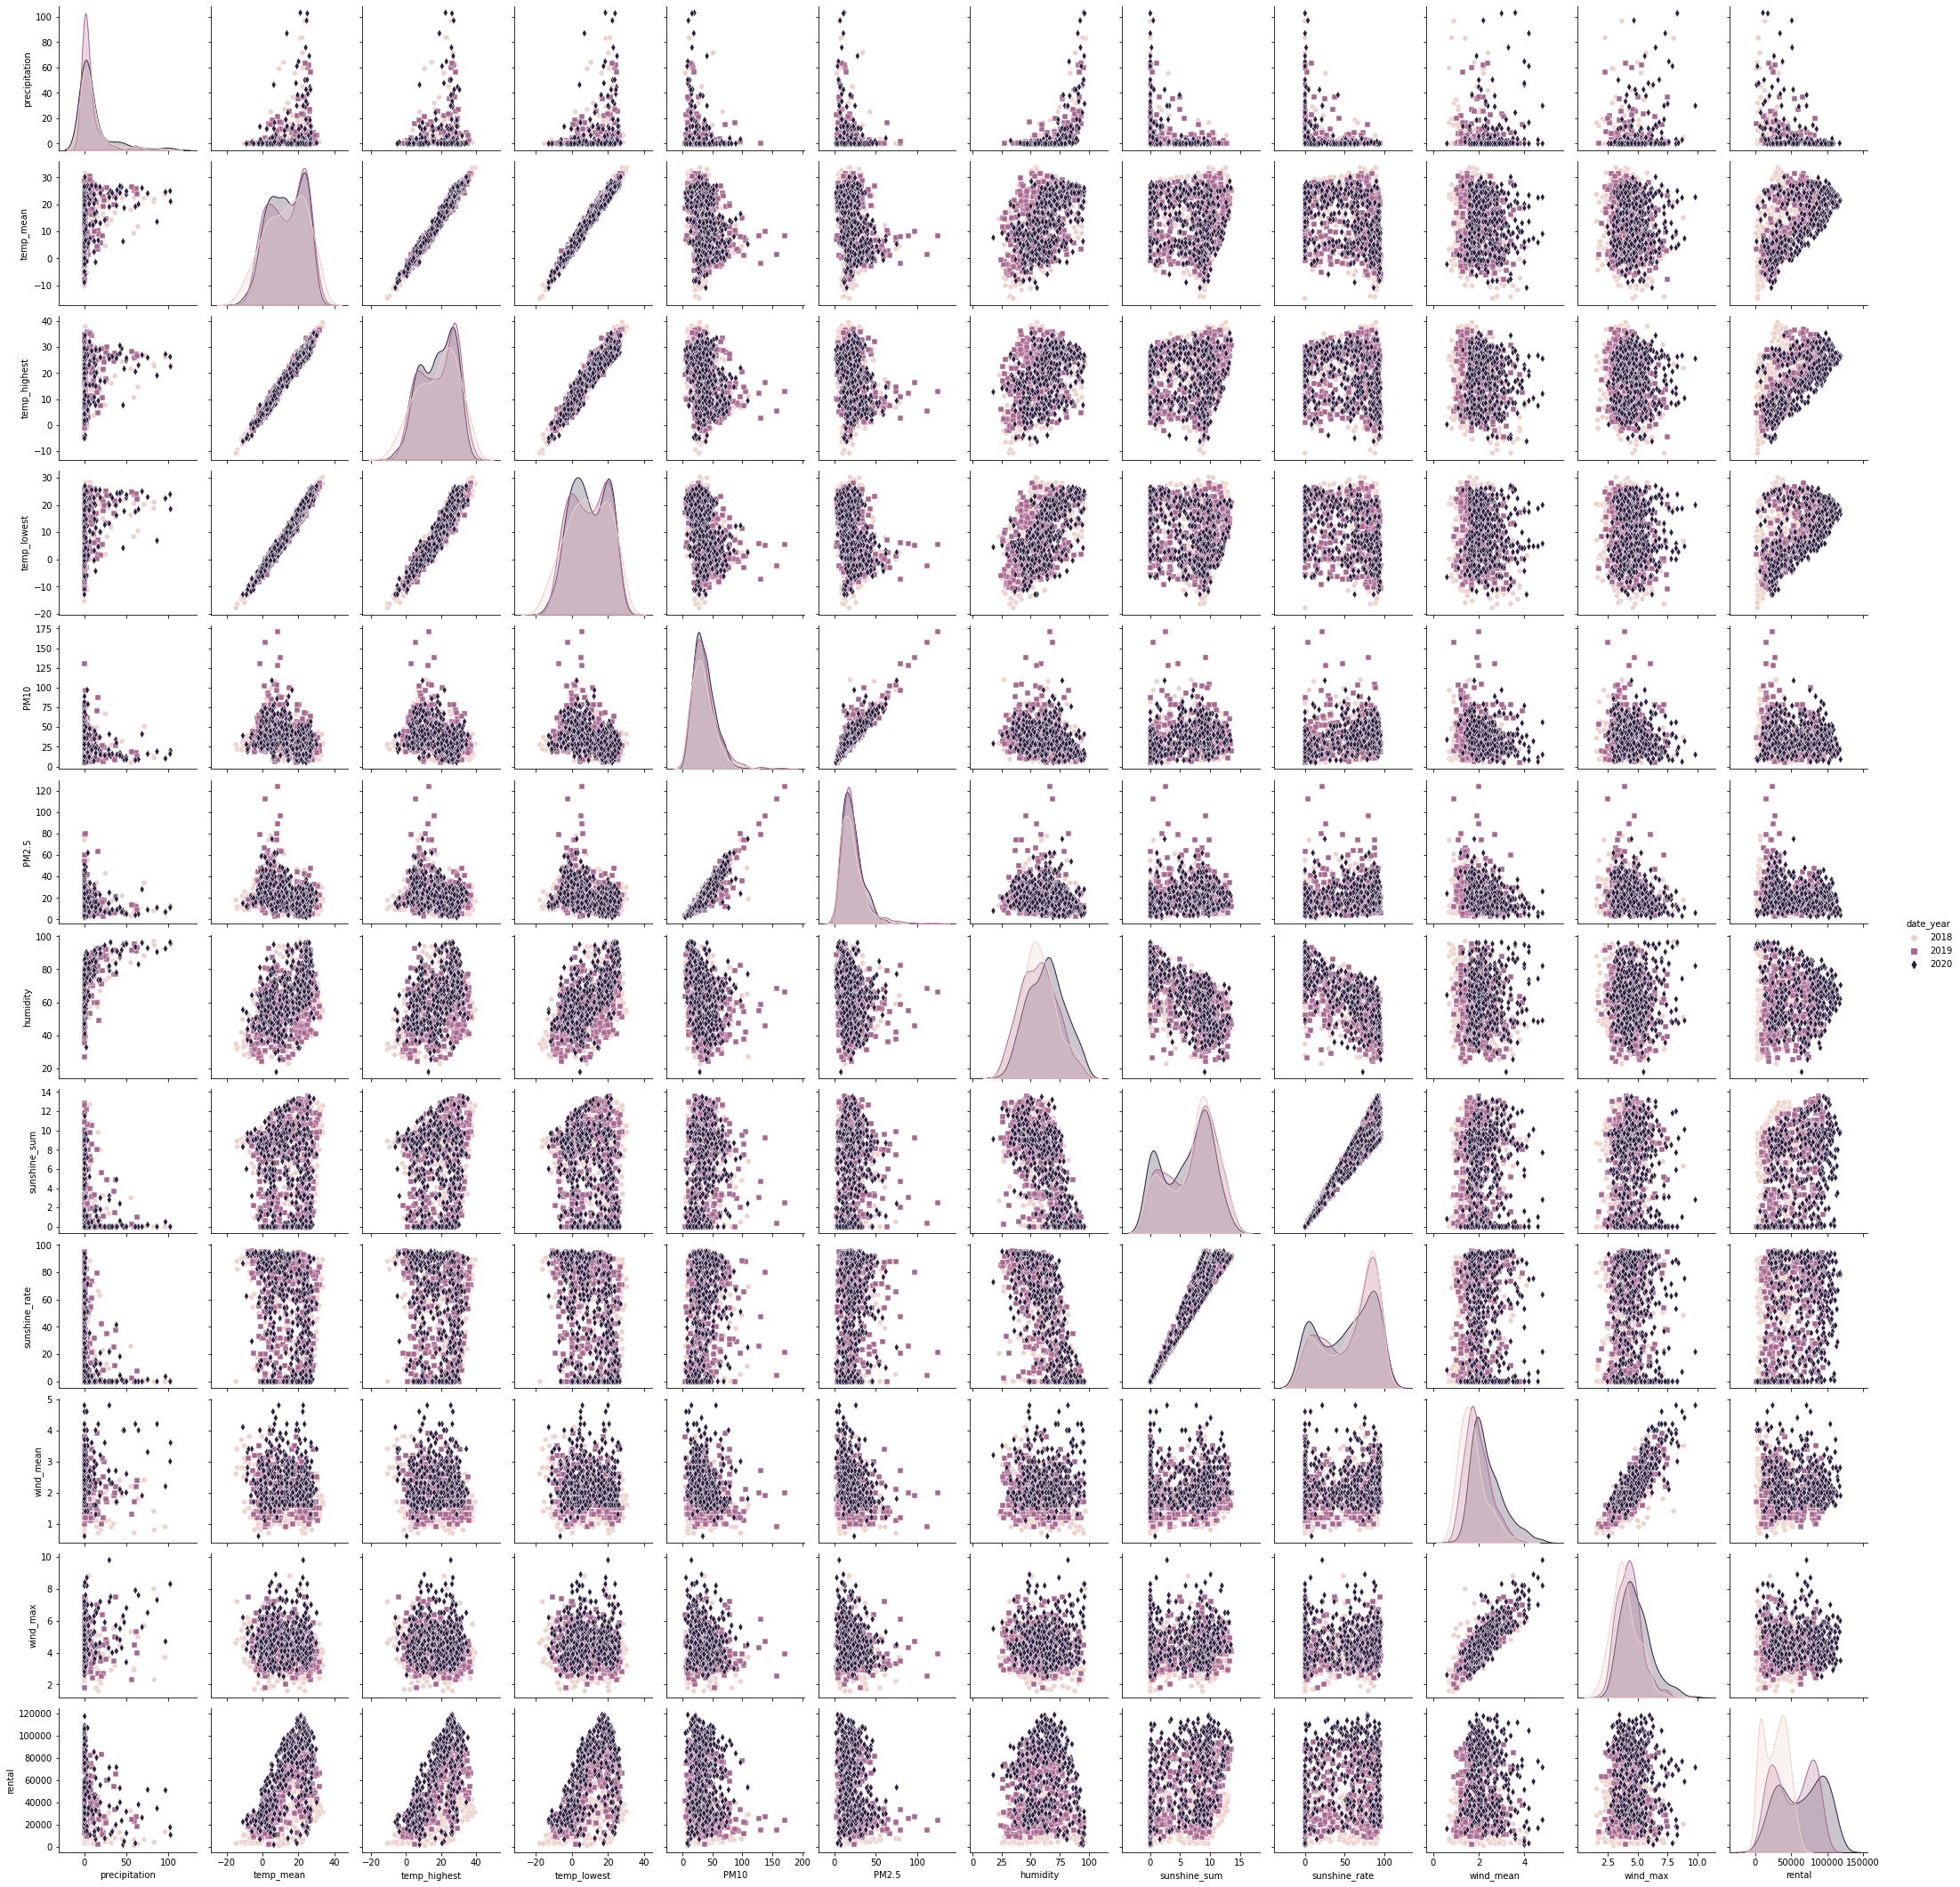

In [13]:
sns.pairplot(data_df, hue = 'date_year', markers = ['o','s','d'])
plt.show()

In [14]:
data_df = data_df.drop('date_month_day', axis = 1)
test_df = test_df.drop('date_month_day', axis = 1)

In [15]:
# 불쾌지수 공식의 활용
def get_discomfort(humididity, temp_highest, temp_lowest):
    # 전체적인 탑승의 경향성을 반영하기 위해 출퇴근 시간의 사용량이 많음에도 불구하고, 평균온도로 고려합니다.
    temp = (temp_lowest + temp_highest)/2
    humididity = humididity / 100
    
    discomfort = 1.8 * temp - 0.558 * (1 - humididity) * (1.8*temp - 26) + 32
    return discomfort

data_df['discomfort'] = [0]*len(data_df)
for i in range(len(data_df)):
    data_df.discomfort[i] = get_discomfort(data_df.humidity[i],
                                          data_df.temp_highest[i],
                                          data_df.temp_lowest[i])
    
test_df['discomfort'] = [0]*len(test_df)
for i in range(len(test_df)):
    test_df.discomfort[i] = get_discomfort(test_df.humidity[i],
                                          test_df.temp_highest[i],
                                          test_df.temp_lowest[i])

/var/folders/wg/5chskr095sb443gt9wr8vplw0000gn/T/ipykernel_2657/1557500212.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.discomfort[i] = get_discomfort(data_df.humidity[i],
/var/folders/wg/5chskr095sb443gt9wr8vplw0000gn/T/ipykernel_2657/1557500212.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.discomfort[i] = get_discomfort(test_df.humidity[i],


In [16]:
# 악조건에 대한 
data_df['cold_measure'] = data_df['temp_lowest']/data_df['wind_max']
test_df['cold_measure'] = test_df['temp_lowest']/test_df['wind_max']
# 체감온도
data_df['feel'] = 13.12 + 0.6215*(data_df['temp_highest']+data_df['temp_lowest'])//2-11.37*data_df['wind_mean']**(0.16) + 0.4*(data_df['temp_highest']+data_df['temp_lowest'])//2*data_df['wind_mean']**(0.16)
test_df['feel'] = 13.12 + 0.6215*(test_df['temp_highest']+test_df['temp_lowest'])//2-11.37*test_df['wind_mean']**(0.16) + 0.4*(test_df['temp_highest']+test_df['temp_lowest'])//2*test_df['wind_mean']**(0.16)
# 일교차
data_df['temp_diff'] = data_df['temp_highest'] - data_df['temp_lowest']
test_df['temp_diff'] = test_df['temp_highest'] - test_df['temp_lowest']

In [17]:
data_df = data_df.drop('humidity', axis =1)
test_df = test_df.drop('humidity', axis =1)

In [18]:
data_df

date  precipitation  temp_mean  temp_highest  temp_lowest  PM10  \
0    2018-01-01            NaN       -1.3           3.8         -5.1  34.0   
1    2018-01-02            NaN       -1.8           1.8         -4.3  36.0   
2    2018-01-03            NaN       -4.7          -0.4         -7.1  31.0   
3    2018-01-04            NaN       -4.7          -0.7         -8.7  39.0   
4    2018-01-05            NaN       -3.0           1.6         -5.6  51.0   
...         ...            ...        ...           ...          ...   ...   
1090 2020-12-27            0.0        5.8          10.0          1.4  70.0   
1091 2020-12-28            1.3        6.7          11.4          4.2  66.0   
1092 2020-12-29            0.2        0.1           4.3         -6.2  69.0   
1093 2020-12-30            NaN      -10.9          -6.2        -12.9  39.0   
1094 2020-12-31            0.0       -8.9          -5.0        -12.9  28.0   

      PM2.5  sunshine_sum  sunshine_rate  wind_mean  wind_max  rental  \
0      17.0           8.3           86.5        1.4       3.8    4950   
1      22.0           7.9           82.3        1.8       4.9    7136   
2      19.0           8.6           88.7        2.2       3.5    7156   
3      24.0           6.2           63.9        1.4       3.5    7102   
4      35.0           8.2           84.5        1.7       3.6    7705   
...     ...           ...            ...        ...       ...     ...   
1090   42.0           5.9           61.5        1.8       2.8   37103   
1091   44.0           8.0           83.3        1.4       3.1   46912   
1092   46.0           0.0            0.0        2.9       6.1   35747   
1093   15.0           8.3           86.5        4.1       6.2   22488   
1094   12.0           6.0           62.5        2.4       4.2   24535   

      date_year  discomfort  cold_measure       feel  temp_diff  
0          2018   40.062964     -1.342105  -0.934198        8.9  
1          2018   38.892830     -0.877551  -1.469807        6.1  
2          2018   35.794387     -2.028571  -5.047676        6.7  
3          2018   34.500348     -2.485714  -3.989509        8.0  
4          2018   36.922669     -1.555556  -2.346090        7.2  
...         ...         ...           ...        ...        ...  
1090       2020   45.518463      0.500000   5.826023        8.6  
1091       2020   47.901957      1.354839   8.287047        7.2  
1092       2020   34.804957     -1.016393  -2.547408       10.5  
1093       2020   25.534509     -2.080645 -12.142794        6.7  
1094       2020   26.722292     -3.071429 -10.561034        7.9  

[1095 rows x 17 columns]

In [19]:
def get_result(pred):
    sub_df['rental'] = pred
    sub_df.to_csv('result.csv', index = False, encoding = 'UTF-8')
def get_nmae(pred,y):
    nmae = np.mean(abs(pred-y)/y)
    return nmae

In [28]:
x = data_df.drop('rental', axis = 1)
y = data_df['rental']

In [ ]:
pip install sklearn

In [ ]:
pip install xgboost

In [29]:
#여기
from xgboost import XGBRegressor as model

In [31]:
#여기
model = XGBRegressor(max_depth = 4, n_estimators = 100)
model.fit(x,y)
pred = 1.2*model.predict(test_df)


# XGBRegressor_model = XGBRegressor(max_depth =4, n_estimators =100)
# XGBRegressor_model.fit(x,y)
# pred = XGBRegressor_model(test_df)

# x_pred = XGBRegressor_model.predict()
# get_nmae(x_pred,y)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:date

# 데이터 plot 진행